### Notes

- want to try a simpler model (Overly complex model gets high accuracy very quickly but is not actually learning all the patterns and features, which results in poor performance on real/unseen data.)
- change the way data is loaded for model training

### Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# FOR COLAB NOTEBOOKS

# Code for colab to mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your zip file and the target directory for extraction
data_directory = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi'

# Load the numpy arrays with allow_pickle=True
cnn_labels = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_labels.npy', allow_pickle=True)
cnn_sequences = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_sequences.npy', allow_pickle=True)
cnn_accessions = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_accessions.npy', allow_pickle=True)
processed_dna_sequences = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/processed_dna_sequences.csv'

In [ ]:
# prompt: can i check the contents of each of those loaded files?

import pandas as pd
# Assuming the previous cell has already loaded the files into variables
# 'cnn_labels', 'cnn_sequences', and 'cnn_accessions' are numpy arrays.
# 'processed_dna_sequences' is a path to a CSV file.

# Print the contents of the numpy arrays (first few elements)
print("Contents of cnn_labels (first 10):")
print(cnn_labels[:10])

print("\nContents of cnn_sequences (first 2):")
# Print a sample of the sequences, they can be large
print(cnn_sequences[:2])

print("\nContents of cnn_accessions (first 10):")
print(cnn_accessions[:10])

# To check the contents of the CSV file, you can read it into a pandas DataFrame
print("\nContents of processed_dna_sequences.csv (first 5 rows):")
try:
    df_processed = pd.read_csv(processed_dna_sequences)
    print(df_processed.head())
except FileNotFoundError:
    print(f"Error: The file {processed_dna_sequences} was not found.")
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")

Contents of cnn_labels (first 10):
['Dengue1' 'Dengue1' 'Dengue1' 'Dengue1' 'Dengue1' 'Dengue1' 'Dengue1'
 'Dengue1' 'Dengue1' 'Dengue1']

Contents of cnn_sequences (first 2):
[[[1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]

Contents of cnn_accessions (first 10):
['NC_001477.1' 'PV798798.1' 'PV789653.1' 'PV344258.1' 'PV344259.1'
 'PV344260.1' 'PV344263.1' 'PV344266.1' 'PV344268.1' 'PV344271.1']

Contents of processed_dna_sequences.csv (first 5 rows):
Error: The file /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/processed_dna_sequences.csv was not found.


### Encoding Labels

In [ ]:
# --- 1. Encode string labels to numerical format and then to one-hot encoded vectors ---
# This part is crucial before training your model.
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(cnn_labels)
num_classes = len(label_encoder.classes_) # Get the total number of unique HA types

# Convert integer labels to one-hot encoded vectors
one_hot_labels = to_categorical(integer_encoded_labels, num_classes=num_classes)

print(f"Original labels (first 5): {cnn_labels[:5]}")
print(f"Integer encoded labels (first 5): {integer_encoded_labels[:5]}")
print(f"Classes: {label_encoder.classes_}")
print(f"One-hot encoded labels (first 5):\n{one_hot_labels[:5]}")
print(f"Shape of one-hot encoded labels: {one_hot_labels.shape}")

Original labels (first 5): ['Dengue1' 'Dengue1' 'Dengue1' 'Dengue1' 'Dengue1']
Integer encoded labels (first 5): [0 0 0 0 0]
Classes: ['Dengue1' 'Dengue2' 'Dengue3' 'Dengue4' 'JapaneseEncephalitisVirus'
 'WestNileVirus' 'Zika']
One-hot encoded labels (first 5):
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
Shape of one-hot encoded labels: (7853, 7)


### Creating datasets

In [ ]:
# --- 2. Split the data into training and testing sets ---
# This is a standard practice to evaluate your model on unseen data.
# Using train_test_split from sklearn.model_selection
# Stratify on one_hot_labels to ensure that each class is represented in the same proportion in both the training and testing sets.
X_train, X_temp, y_train, y_temp = train_test_split(cnn_sequences, one_hot_labels, test_size=0.3, random_state=42, stratify=one_hot_labels)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the shapes of the splits to ensure they are correct
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Reshape the sequences to be in the format (samples, sequence_length, 1, 4)
# This is often required for Conv2D layers in TensorFlow/Keras
# Assuming your sequence data is currently in the format (samples, sequence_length, 4)
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(f"\nShape of X_train after reshaping: {X_train.shape}")
print(f"Shape of X_val after reshaping: {X_val.shape}")
print(f"Shape of X_test after reshaping: {X_test.shape}")

Shape of X_train: (5497, 11520, 4)
Shape of y_train: (5497, 7)
Shape of X_val: (1178, 11520, 4)
Shape of y_val: (1178, 7)
Shape of X_test: (1178, 11520, 4)
Shape of y_test: (1178, 7)

Shape of X_train after reshaping: (5497, 11520, 1, 4)
Shape of X_val after reshaping: (1178, 11520, 1, 4)
Shape of X_test after reshaping: (1178, 11520, 1, 4)


In [ ]:
# --- Using tf.data.Dataset for creating data pipelines ---

# 1. Create TensorFlow Datasets from your numpy arrays
# X_split contains the reshaped sequences (samples, sequence_length, 1, 4)
# y_split contains the one-hot encoded labels (samples, num_classes)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


# 2. Shuffle the training dataset
# Use a buffer size at least as large as your dataset size for full shuffling
buffer_size = len(X_train) # Or a large enough number
train_dataset = train_dataset.shuffle(buffer_size, reshuffle_each_iteration=True) # reshuffle_each_iteration=True is generally good practice


# 3. Define split percentages
# This is no longer needed as the data has already been split


# 4. Split the dataset into training, validation, and test sets
# This is no longer needed as the data has already been split


# 5. Batch the datasets for training
batch_size = 50 # Use the same batch size as before
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Optional: Prefetch data for performance
# This allows the data loading pipeline to fetch data while the GPU is busy with training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets created using tf.data.Dataset:")
print(f"- Train Dataset: {train_dataset}")
print(f"- Validation Dataset: {val_dataset}")
print(f"- Test Dataset: {test_dataset}")

# Now you can use these datasets directly with model.fit(), model.evaluate(), and model.predict()
# Example (do not run in this cell):
# history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
# loss, accuracy = model.evaluate(test_dataset)
# predictions = model.predict(test_dataset)

Datasets created using tf.data.Dataset:
- Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>
- Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>
- Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>


# Task
Load the CNN labels and sequences, sample the data to have a specific number of samples for each class, encode the sampled labels, split the sampled and encoded data into training, validation, and test sets, create TensorFlow Datasets from the split data, and confirm that the sampling and splitting were successful and the datasets are ready for model training.

## Load data

### Subtask:
Load the CNN labels and sequences.


## Sample data by class

### Subtask:
Sample the data to have a specific number of samples for each class based on the `cnn_labels`.


**Reasoning**:
Sample the data to have a specific number of samples for each class based on the `cnn_labels` by iterating through each unique class, identifying corresponding indices, randomly sampling a defined number of indices for each class (or all available if less than the desired number), and then collecting the sequences and labels for these sampled indices into new arrays, finally printing their shapes to confirm the process.



In [ ]:
# 1. Define the desired number of samples per class
samples_per_class = 500

# 2. Initialize empty lists to store the sampled sequences and labels
sampled_sequences = []
sampled_labels = []

# Get unique classes
unique_classes = np.unique(cnn_labels)

# 3. Iterate through each unique class
for class_name in unique_classes:
    # 4. For each class, identify the indices in cnn_labels that correspond to that class
    class_indices = np.where(cnn_labels == class_name)[0]

    # 5. Randomly sample samples_per_class indices from the identified indices.
    #    If the number of available samples for a class is less than samples_per_class,
    #    use all available indices for that class.
    num_available_samples = len(class_indices)
    if num_available_samples > samples_per_class:
        sampled_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
    else:
        sampled_indices = class_indices

    # 6. Append the sequences from cnn_sequences corresponding to the sampled indices to sampled_sequences
    sampled_sequences.extend(cnn_sequences[sampled_indices])

    # 7. Append the labels from cnn_labels corresponding to the sampled indices to sampled_labels
    sampled_labels.extend(cnn_labels[sampled_indices])

# 8. Convert the sampled_sequences and sampled_labels lists into numpy arrays
sampled_sequences = np.array(sampled_sequences)
sampled_labels = np.array(sampled_labels)

# 9. Print the shapes of the resulting sampled sequences and labels to confirm the sampling was applied
print(f"Shape of sampled_sequences: {sampled_sequences.shape}")
print(f"Shape of sampled_labels: {sampled_labels.shape}")

Shape of sampled_sequences: (3126, 11520, 4)
Shape of sampled_labels: (3126,)


**Reasoning**:
The data has been sampled. The next step is to encode the sampled labels into a numerical format and then to one-hot encoded vectors for model training, following the original plan.



In [ ]:
# Encode string labels to numerical format and then to one-hot encoded vectors
label_encoder = LabelEncoder()
integer_encoded_sampled_labels = label_encoder.fit_transform(sampled_labels)
num_classes = len(label_encoder.classes_)

# Convert integer labels to one-hot encoded vectors
one_hot_sampled_labels = to_categorical(integer_encoded_sampled_labels, num_classes=num_classes)

print(f"Original sampled labels (first 5): {sampled_labels[:5]}")
print(f"Integer encoded sampled labels (first 5): {integer_encoded_sampled_labels[:5]}")
print(f"Classes: {label_encoder.classes_}")
print(f"One-hot encoded sampled labels (first 5):\n{one_hot_sampled_labels[:5]}")
print(f"Shape of one-hot encoded sampled labels: {one_hot_sampled_labels.shape}")

Original sampled labels (first 5): ['Dengue1' 'Dengue1' 'Dengue1' 'Dengue1' 'Dengue1']
Integer encoded sampled labels (first 5): [0 0 0 0 0]
Classes: ['Dengue1' 'Dengue2' 'Dengue3' 'Dengue4' 'JapaneseEncephalitisVirus'
 'WestNileVirus' 'Zika']
One-hot encoded sampled labels (first 5):
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
Shape of one-hot encoded sampled labels: (3126, 7)


**Reasoning**:
Split the sampled and encoded data into training, validation, and test sets and then reshape the sequences for compatibility with Conv2D layers, followed by printing the shapes of the resulting splits to confirm the process.



In [ ]:
# Split the sampled data into training, validation, and testing sets
# Stratify on one_hot_sampled_labels to ensure that each class is represented in the same proportion in the splits.
X_train_sampled, X_temp_sampled, y_train_sampled, y_temp_sampled = train_test_split(
    sampled_sequences, one_hot_sampled_labels, test_size=0.3, random_state=42, stratify=one_hot_sampled_labels
)

# Split the temporary set into validation and test sets
X_val_sampled, X_test_sampled, y_val_sampled, y_test_sampled = train_test_split(
    X_temp_sampled, y_temp_sampled, test_size=0.5, random_state=42, stratify=y_temp_sampled
)

# Check the shapes of the splits to ensure they are correct
print(f"Shape of X_train_sampled: {X_train_sampled.shape}")
print(f"Shape of y_train_sampled: {y_train_sampled.shape}")
print(f"Shape of X_val_sampled: {X_val_sampled.shape}")
print(f"Shape of y_val_sampled: {y_val_sampled.shape}")
print(f"Shape of X_test_sampled: {X_test_sampled.shape}")
print(f"Shape of y_test_sampled: {y_test_sampled.shape}")

# Reshape the sequences to be in the format (samples, sequence_length, 1, 4)
# This is often required for Conv2D layers in TensorFlow/Keras
X_train_sampled = np.expand_dims(X_train_sampled, axis=2)
X_val_sampled = np.expand_dims(X_val_sampled, axis=2)
X_test_sampled = np.expand_dims(X_test_sampled, axis=2)

print(f"\nShape of X_train_sampled after reshaping: {X_train_sampled.shape}")
print(f"Shape of X_val_sampled after reshaping: {X_val_sampled.shape}")
print(f"Shape of X_test_sampled after reshaping: {X_test_sampled.shape}")

Shape of X_train_sampled: (2188, 11520, 4)
Shape of y_train_sampled: (2188, 7)
Shape of X_val_sampled: (469, 11520, 4)
Shape of y_val_sampled: (469, 7)
Shape of X_test_sampled: (469, 11520, 4)
Shape of y_test_sampled: (469, 7)

Shape of X_train_sampled after reshaping: (2188, 11520, 1, 4)
Shape of X_val_sampled after reshaping: (469, 11520, 1, 4)
Shape of X_test_sampled after reshaping: (469, 11520, 1, 4)


**Reasoning**:
Create TensorFlow Datasets from the split and reshaped data, applying shuffling and batching for efficient training, and then print information about the created datasets to confirm they are ready for model training.



In [ ]:
# Create TensorFlow Datasets from the numpy arrays
train_dataset_sampled = tf.data.Dataset.from_tensor_slices((X_train_sampled, y_train_sampled))
val_dataset_sampled = tf.data.Dataset.from_tensor_slices((X_val_sampled, y_val_sampled))
test_dataset_sampled = tf.data.Dataset.from_tensor_slices((X_test_sampled, y_test_sampled))

# Shuffle the training dataset
buffer_size_sampled = len(X_train_sampled)
train_dataset_sampled = train_dataset_sampled.shuffle(buffer_size_sampled, reshuffle_each_iteration=True)

# Batch the datasets for training
batch_size = 50 # Using the same batch size as before
train_dataset_sampled = train_dataset_sampled.batch(batch_size)
val_dataset_sampled = val_dataset_sampled.batch(batch_size)
test_dataset_sampled = test_dataset_sampled.batch(batch_size)

# Prefetch data for performance
train_dataset_sampled = train_dataset_sampled.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset_sampled = val_dataset_sampled.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_sampled = test_dataset_sampled.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets created using tf.data.Dataset from sampled data:")
print(f"- Train Dataset Sampled: {train_dataset_sampled}")
print(f"- Validation Dataset Sampled: {val_dataset_sampled}")
print(f"- Test Dataset Sampled: {test_dataset_sampled}")

Datasets created using tf.data.Dataset from sampled data:
- Train Dataset Sampled: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>
- Validation Dataset Sampled: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>
- Test Dataset Sampled: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>


**Reasoning**:
Confirm that the sampling and splitting were successful and the datasets are ready for model training by printing the sizes of the original and sampled datasets, checking the class distribution in the sampled dataset, and verifying the structure of the created TensorFlow datasets.



In [ ]:
# Confirm sampling and splitting were successful

# Print the size of the original dataset
print(f"Original dataset size: {len(cnn_labels)}")

# Print the size of the sampled dataset
print(f"Sampled dataset size: {len(sampled_labels)}")

# Check the class distribution in the sampled dataset
unique_sampled_classes, counts_sampled = np.unique(sampled_labels, return_counts=True)
print("\nClass distribution in sampled dataset:")
for class_name, count in zip(unique_sampled_classes, counts_sampled):
    print(f"- {class_name}: {count}")

# Verify the structure of the created TensorFlow datasets
print("\nTensorFlow Datasets structure:")
for element in train_dataset_sampled.take(1):
    print(f"- Train dataset element spec: {element}")

for element in val_dataset_sampled.take(1):
    print(f"- Validation dataset element spec: {element}")

for element in test_dataset_sampled.take(1):
    print(f"- Test dataset element spec: {element}")

print("\nSampling, splitting, and dataset creation for sampled data confirmed.")

Original dataset size: 7853
Sampled dataset size: 3126

Class distribution in sampled dataset:
- Dengue1: 500
- Dengue2: 500
- Dengue3: 500
- Dengue4: 256
- JapaneseEncephalitisVirus: 500
- WestNileVirus: 500
- Zika: 370

TensorFlow Datasets structure:
- Train dataset element spec: (<tf.Tensor: shape=(50, 11520, 1, 4), dtype=float32, numpy=
array([[[[1., 0., 0., 0.]],

        [[0., 0., 0., 1.]],

        [[0., 0., 1., 0.]],

        ...,

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]],


       [[[0., 0., 1., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 1., 0., 0.]],

        ...,

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]],


       [[[1., 0., 0., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        ...,

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]],


       ...,


       [[[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0

## Encode labels

### Subtask:
Encode the sampled labels to numerical format and then to one-hot encoded vectors.


**Reasoning**:
Encode the sampled labels to numerical format and then to one-hot encoded vectors as per the instructions.



In [ ]:
# 1. Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# 2. Fit the LabelEncoder to the sampled_labels array and transform the labels into integer format
integer_encoded_sampled_labels = label_encoder.fit_transform(sampled_labels)

# 3. Determine the number of unique classes from the fitted label_encoder
num_classes = len(label_encoder.classes_)

# 4. Convert the integer_encoded_sampled_labels into one-hot encoded vectors
one_hot_sampled_labels = to_categorical(integer_encoded_sampled_labels, num_classes=num_classes)

# 5. Print the first few original sampled labels, the first few integer encoded sampled labels,
#    the list of classes found by the encoder, the shape of the one-hot encoded labels,
#    and the first few rows of the one-hot encoded labels to verify the encoding process.
print(f"Original sampled labels (first 5): {sampled_labels[:5]}")
print(f"Integer encoded sampled labels (first 5): {integer_encoded_sampled_labels[:5]}")
print(f"Classes: {label_encoder.classes_}")
print(f"Shape of one-hot encoded sampled labels: {one_hot_sampled_labels.shape}")
print(f"One-hot encoded sampled labels (first 5):\n{one_hot_sampled_labels[:5]}")

Original sampled labels (first 5): ['Dengue1' 'Dengue1' 'Dengue1' 'Dengue1' 'Dengue1']
Integer encoded sampled labels (first 5): [0 0 0 0 0]
Classes: ['Dengue1' 'Dengue2' 'Dengue3' 'Dengue4' 'JapaneseEncephalitisVirus'
 'WestNileVirus' 'Zika']
Shape of one-hot encoded sampled labels: (3126, 7)
One-hot encoded sampled labels (first 5):
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


## Split data

### Subtask:
Split the sampled and encoded data into training, validation, and test sets.


**Reasoning**:
Split the sampled sequences and one-hot encoded labels into training, validation, and test sets, reshape the sequence data, and print the shapes to confirm.



In [ ]:
# Split the sampled data into training, validation, and testing sets
# Stratify on one_hot_sampled_labels to ensure that each class is represented in the same proportion in the splits.
X_train_sampled, X_temp_sampled, y_train_sampled, y_temp_sampled = train_test_split(
    sampled_sequences, one_hot_sampled_labels, test_size=0.3, random_state=42, stratify=one_hot_sampled_labels
)

# Split the temporary set into validation and test sets
X_val_sampled, X_test_sampled, y_val_sampled, y_test_sampled = train_test_split(
    X_temp_sampled, y_temp_sampled, test_size=0.5, random_state=42, stratify=y_temp_sampled
)

# Check the shapes of the splits to ensure they are correct
print(f"Shape of X_train_sampled: {X_train_sampled.shape}")
print(f"Shape of y_train_sampled: {y_train_sampled.shape}")
print(f"Shape of X_val_sampled: {X_val_sampled.shape}")
print(f"Shape of y_val_sampled: {y_val_sampled.shape}")
print(f"Shape of X_test_sampled: {X_test_sampled.shape}")
print(f"Shape of y_test_sampled: {y_test_sampled.shape}")

# Reshape the sequences to be in the format (samples, sequence_length, 1, 4)
# This is often required for Conv2D layers in TensorFlow/Keras
X_train_sampled = np.expand_dims(X_train_sampled, axis=2)
X_val_sampled = np.expand_dims(X_val_sampled, axis=2)
X_test_sampled = np.expand_dims(X_test_sampled, axis=2)

print(f"\nShape of X_train_sampled after reshaping: {X_train_sampled.shape}")
print(f"Shape of X_val_sampled after reshaping: {X_val_sampled.shape}")
print(f"Shape of X_test_sampled after reshaping: {X_test_sampled.shape}")

Shape of X_train_sampled: (2188, 11520, 4)
Shape of y_train_sampled: (2188, 7)
Shape of X_val_sampled: (469, 11520, 4)
Shape of y_val_sampled: (469, 7)
Shape of X_test_sampled: (469, 11520, 4)
Shape of y_test_sampled: (469, 7)

Shape of X_train_sampled after reshaping: (2188, 11520, 1, 4)
Shape of X_val_sampled after reshaping: (469, 11520, 1, 4)
Shape of X_test_sampled after reshaping: (469, 11520, 1, 4)


## Create tensorflow datasets

### Subtask:
Create TensorFlow Datasets from the split data.


**Reasoning**:
Create TensorFlow Datasets from the split numpy arrays, shuffle the training dataset, batch all datasets, and apply prefetching for performance.



In [ ]:
# 1. Create TensorFlow Datasets from your numpy arrays
# X_split_sampled contains the reshaped sequences (samples, sequence_length, 1, 4)
# y_split_sampled contains the one-hot encoded labels (samples, num_classes)
train_dataset_sampled = tf.data.Dataset.from_tensor_slices((X_train_sampled, y_train_sampled))
val_dataset_sampled = tf.data.Dataset.from_tensor_slices((X_val_sampled, y_val_sampled))
test_dataset_sampled = tf.data.Dataset.from_tensor_slices((X_test_sampled, y_test_sampled))

# 2. Shuffle the training dataset
# Use a buffer size at least as large as your dataset size for full shuffling
buffer_size_sampled = len(X_train_sampled)
train_dataset_sampled = train_dataset_sampled.shuffle(buffer_size_sampled, reshuffle_each_iteration=True)

# 3. Batch the datasets for training
batch_size = 50 # Use the same batch size as before
train_dataset_sampled = train_dataset_sampled.batch(batch_size)
val_dataset_sampled = val_dataset_sampled.batch(batch_size)
test_dataset_sampled = test_dataset_sampled.batch(batch_size)

# 4. Apply prefetching to the batched datasets for performance
# This allows the data loading pipeline to fetch data while the GPU is busy with training
train_dataset_sampled = train_dataset_sampled.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset_sampled = val_dataset_sampled.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_sampled = test_dataset_sampled.prefetch(buffer_size=tf.data.AUTOTUNE)

# 5. Print the resulting TensorFlow Dataset objects
print("Datasets created using tf.data.Dataset from sampled data:")
print(f"- Train Dataset Sampled: {train_dataset_sampled}")
print(f"- Validation Dataset Sampled: {val_dataset_sampled}")
print(f"- Test Dataset Sampled: {test_dataset_sampled}")

Datasets created using tf.data.Dataset from sampled data:
- Train Dataset Sampled: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>
- Validation Dataset Sampled: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>
- Test Dataset Sampled: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 11520, 1, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>


**Reasoning**:
Confirm that the sampling and splitting were successful and the datasets are ready for model training.



In [ ]:
# Confirm sampling and splitting were successful

# Print the size of the original dataset
print(f"Original dataset size: {len(cnn_labels)}")

# Print the size of the sampled dataset
print(f"Sampled dataset size: {len(sampled_labels)}")

# Check the class distribution in the sampled dataset
unique_sampled_classes, counts_sampled = np.unique(sampled_labels, return_counts=True)
print("\nClass distribution in sampled dataset:")
for class_name, count in zip(unique_sampled_classes, counts_sampled):
    print(f"- {class_name}: {count}")

# Verify the structure of the created TensorFlow datasets
print("\nTensorFlow Datasets structure:")
for element in train_dataset_sampled.take(1):
    print(f"- Train dataset element spec: {element}")

for element in val_dataset_sampled.take(1):
    print(f"- Validation dataset element spec: {element}")

for element in test_dataset_sampled.take(1):
    print(f"- Test dataset element spec: {element}")

print("\nSampling, splitting, and dataset creation for sampled data confirmed.")

Original dataset size: 7853
Sampled dataset size: 3126

Class distribution in sampled dataset:
- Dengue1: 500
- Dengue2: 500
- Dengue3: 500
- Dengue4: 256
- JapaneseEncephalitisVirus: 500
- WestNileVirus: 500
- Zika: 370

TensorFlow Datasets structure:
- Train dataset element spec: (<tf.Tensor: shape=(50, 11520, 1, 4), dtype=float32, numpy=
array([[[[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 1.]],

        ...,

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]],


       [[[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 1.]],

        ...,

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]],


       [[[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 1.]],

        ...,

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]],


       ...,


       [[[1., 0., 0., 0.]],

        [[0., 1., 0., 0.]],

        [[1., 0

## Summary:

### Data Analysis Key Findings

*   The original dataset contained 7853 samples.
*   After sampling to a maximum of 500 samples per class, the dataset size was reduced to 3126 samples.
*   The sampled labels were successfully encoded into 7 unique classes using one-hot encoding.
*   The sampled data was split into training (2188 samples), validation (469 samples), and test (469 samples) sets with a 70/15/15 ratio using stratified splitting.
*   The sequence data was reshaped to the format (samples, sequence\_length, 1, 4) for compatibility with Conv2D layers.
*   TensorFlow Datasets were successfully created from the split numpy arrays and configured for efficient training with shuffling, batching (batch size 50), and prefetching.

### Insights or Next Steps

*   The class distribution in the sampled dataset is more balanced than the original, but some classes still have fewer than 500 samples. This might require further consideration during model evaluation or training (e.g., using class weights).
*   The datasets are now prepared and optimized for training a CNN model using TensorFlow. The next step is to define and train the CNN model using these datasets.


### Model Structure

In [ ]:

# --- 3. Define the CNN Model Structure ---

# Input shape for Conv2D should be (height, width, channels)
# Here, 'height' is your sequence length, 'width' is 1 (the dummy dimension we added),
# and 'channels' is 4 (for A, C, G, T).
input_shape_for_conv2d = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = models.Sequential()

# Input Layer: Specifies the expected shape of individual samples (excluding batch size)
model.add(layers.Input(shape=input_shape_for_conv2d))

# Convolutional Layers
model.add(layers.Conv2D(16, kernel_size=(21, 1), strides=(10, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Print a summary of the model to see the layer outputs and parameter counts
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 1152, 1, 16)    │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 576, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │       147,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,951 (581.84 KB)

 Trainable params: 148,951 (581.84 KB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation

In [ ]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel compiled successfully.")


Model compiled successfully.


### Model Training

In [ ]:
# prompt: fit and train the model with the sampled training and validation data

# Train the model with the sampled training and validation data
epochs = 10 # Define the number of training epochs

history = model.fit(
    train_dataset_sampled,      # Use the sampled training dataset
    epochs=epochs,
    validation_data=val_dataset_sampled # Use the sampled validation dataset
)

print("\nModel training complete.")

# You can access training history like this:
# history.history['loss']
# history.history['accuracy']
# history.history['val_loss']
# history.history['val_accuracy']

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.3652 - loss: 1.7235 - val_accuracy: 0.7868 - val_loss: 0.8707
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7565 - loss: 0.8671 - val_accuracy: 0.8806 - val_loss: 0.5372
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.8256 - loss: 0.6069 - val_accuracy: 0.9147 - val_loss: 0.4143
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8844 - loss: 0.4370 - val_accuracy: 0.9190 - val_loss: 0.3492
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9143 - loss: 0.3566 - val_accuracy: 0.9403 - val_loss: 0.2913
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9200 - loss: 0.3165 - val_accuracy: 0.9360 - val_loss: 0.2526
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9397 - loss: 0.2610 - val_accuracy: 0.9531 - val_loss: 0.2107
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9484 - loss: 0.2290 - val_accuracy: 0.9382 -

In [ ]:
#save the model

model.save('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model5_flavi.keras')


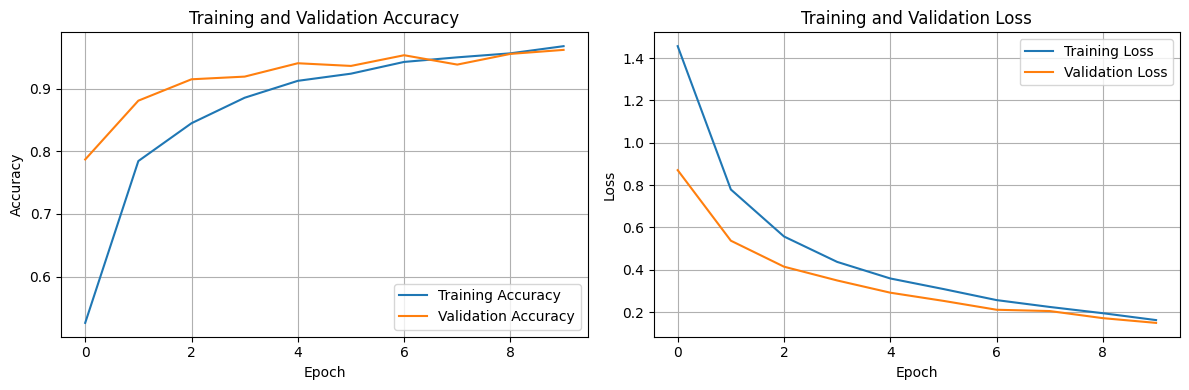

In [ ]:
# prompt: plot training and validation loss and accuracy graphs

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Load the model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model5_flavi.keras')

In [ ]:
# 1. Get predictions from the model
# model.predict returns probabilities for each class
y_pred_probabilities = model.predict(X_test)

# 2. Convert probabilities to predicted class labels
# np.argmax will give you the index of the highest probability
predicted_integer_labels = np.argmax(y_pred_probabilities, axis=1)

# 3. If you want to see the human-readable HA types,
# use the label_encoder to inverse transform the integer labels
predicted_virus_types = label_encoder.inverse_transform(predicted_integer_labels)

# 4. Get the true labels in human-readable format for comparison
true_integer_labels = np.argmax(y_test, axis=1) # Convert y_test back from one-hot to integer
true_virus_types = label_encoder.inverse_transform(true_integer_labels)


# Overall model performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Test Loss: 0.1784
Test Accuracy: 0.9610


<Figure size 1000x800 with 0 Axes>

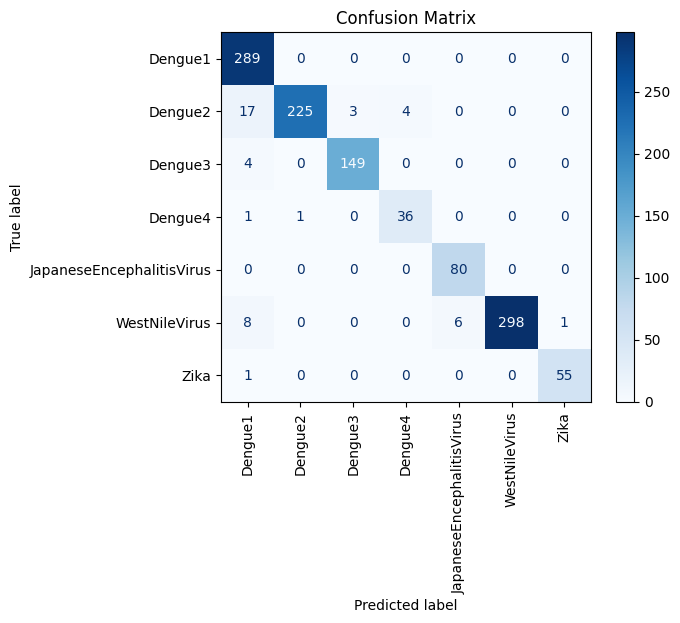


Confusion matrix generated.


In [ ]:
# prompt: can you generate a confusion matrix for the test data

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(true_integer_labels, predicted_integer_labels)

# Get the class names
class_names = label_encoder.classes_

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion matrix generated.")


### Testing Codes

In [ ]:
def preprocess_sequence_for_cnn(sequence_string, target_length=11520):
    """
    Preprocesses a single DNA sequence string for input into the CNN model,
    padding or truncating to a target length.

    Args:
        sequence_string (str): The DNA sequence string (e.g., "AAGTTG...").
        target_length (int): The desired length of the sequence after padding/truncation.

    Returns:
        np.ndarray: The preprocessed sequence as a numpy array,
                    reshaped to (1, target_length, 1, 4) for the CNN.
    """
    # Define the mapping for one-hot encoding
    nucleotide_map = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]} # Handle 'N' as all zeros

    # Pad or truncate the sequence to the target length
    if len(sequence_string) < target_length:
        # Pad with 'N' to the target length
        padded_sequence = sequence_string + 'N' * (target_length - len(sequence_string))
    elif len(sequence_string) > target_length:
        # Truncate the sequence
        padded_sequence = sequence_string[:target_length]
    else:
        # Sequence is already the target length
        padded_sequence = sequence_string

    # Convert the padded/truncated sequence string to a list of one-hot encoded vectors
    encoded_sequence = [nucleotide_map.get(base.upper(), [0, 0, 0, 0]) for base in padded_sequence] # Handle unknown bases

    # Convert the list to a numpy array
    encoded_sequence_array = np.array(encoded_sequence, dtype=np.float32)

    # Reshape for the CNN: (1, target_length, 1, 4)
    # Add a batch dimension (1), a width dimension (1), and keep height (target_length) and channels (4)
    preprocessed_input = np.expand_dims(encoded_sequence_array, axis=0) # Add batch dimension
    preprocessed_input = np.expand_dims(preprocessed_input, axis=2) # Add width dimension

    return preprocessed_input

In [ ]:
# Load the model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model5_flavi.keras')

In [ ]:
# Example Usage:
# Assuming you have a new sequence string you want to test
# Use a sequence of the same length as the training data (11520) or a different length to test padding/truncation
new_dna_sequence = "CTGTATAAAGGTGCTGTGCCCATACACCAGCACTATGATGGAAACCATGGAGCGACTGCAACGTAGGCATGGGGGAGGATTAGTCAGAGTGCCATTGTGTCGCAACTCCACACATGAGATGTACTGGGTCTCTGGGGCAAAGAGCAACATCATAAAAAGTGTGTCCACCACAAGTCAGCTCCTCCTGGGACGCATGGATGGCCCCAGGAGGCCAGTGAAATATGAGGAGGATGTGAACCTCGGCTCGGGTACACGAGCTGTGGCAAGCTGTGCTGAGGCTCCTAACATGAAAATCATCGGCAGGCGCATTGAGAGAATCCGCAATGAACATGCAGAAACATGGTTTCTTGATGAAAACCACCCATACAGGACATGGGCCTACCATGGGAGCTACGAAGCCCCCACGCAAGGATCAGCGTCTTCCCTCGTGAACGGGGTTGTTAGACTCCTGTCAAAGCCTTGGGACGTGGTGACTGGAGTTACAGGAATAGCCATGACTGACACCACACCATACGGCCAACAAAGAGTCTTCAAAGAAAAAGTGGACACCAGGGTGCCAG"

# Specify the target length that the model was trained on
target_sequence_length = 11520 # This should match the sequence length of your training data (X_train.shape[1])

preprocessed_sequence = preprocess_sequence_for_cnn(new_dna_sequence, target_length=target_sequence_length)

print(f"Original sequence string length: {len(new_dna_sequence)}")
print(f"Preprocessed sequence shape for CNN: {preprocessed_sequence.shape}")

# Now you can use this preprocessed_sequence as input to your trained model's predict method
prediction = model.predict(preprocessed_sequence)
print(f"Prediction output shape: {prediction.shape}")
predicted_class_index = np.argmax(prediction)
predicted_virus_type = label_encoder.classes_[predicted_class_index]
print(f"Predicted Virus Type: {predicted_virus_type}")

Original sequence string length: 560
Preprocessed sequence shape for CNN: (1, 11520, 1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction output shape: (1, 7)
Predicted Virus Type: JapaneseEncephalitisVirus


In [ ]:
# prompt: i want to run the test codes on gradio, how do i do that? can gradio remove any line breaks in the sequence submitted for prediction?

import numpy as np
!pip install -q gradio

import gradio as gr


def predict_virus_type(sequence_string):
    # Clean the input sequence string: remove whitespace and newline characters
    cleaned_sequence_string = "".join(sequence_string.split())

    # Preprocess the input sequence
    target_sequence_length = 11520
    preprocessed_sequence = preprocess_sequence_for_cnn(cleaned_sequence_string, target_length=target_sequence_length)

    # Get prediction from the model
    prediction = model.predict(preprocessed_sequence)[0] # Get the prediction for the single input

    # Get the predicted class index and convert to virus type
    predicted_class_index = np.argmax(prediction)
    predicted_virus_type = label_encoder.classes_[predicted_class_index]

    # Format the output as a dictionary for gr.Label
    confidence_scores = {}
    for i, class_name in enumerate(label_encoder.classes_):
        confidence_scores[class_name] = float(prediction[i]) # Convert numpy float to Python float

    return predicted_virus_type, confidence_scores # Return both the predicted type and the confidence scores dictionary


# Create the Gradio interface
iface = gr.Interface(
    fn=predict_virus_type,
    inputs=gr.Textbox(label="Enter DNA Sequence"),
    outputs=[
        gr.Textbox(label="Predicted Virus Type"), # Output for the predicted type
        gr.Label(label="Prediction Confidence Scores") # Output for the colored bars
    ],
    title="DNA Sequence Virus Type Predictor",
    description="Enter a DNA sequence to predict the virus type and see confidence scores for all classes."
)

# Launch the interface
iface.launch(debug=True)



It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c9ed56c02cd905fd01.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://c9ed56c02cd905fd01.gradio.live


In [ ]:
# Regarding line breaks:
# Gradio's Textbox input component by default treats the input as a single string.
# If a user enters a sequence with line breaks in the Gradio UI's Textbox,
# Gradio will pass this input string to your `predict_virus_type` function.
# The `sequence_string` variable in your function will contain these line breaks
# as newline characters ('\n').

# Your current `preprocess_sequence_for_cnn` function iterates through the characters
# in the input string. It will encounter these newline characters.
# The line `nucleotide_map.get(base.upper(), [0, 0, 0, 0])` handles characters
# not in 'A', 'C', 'G', 'T', 'N' by returning `[0, 0, 0, 0]`.
# This effectively treats newline characters (or any other non-nucleotide characters)
# as 'N's during the one-hot encoding process.

# If you explicitly want to remove line breaks (and potentially other whitespace),
# you can add a cleaning step at the beginning of your `predict_virus_type` function:



# By using `"".join(sequence_string.split())`, you remove all whitespace characters,
# including spaces, tabs, and newlines. This ensures only the nucleotide
# characters (and potentially others not in the `nucleotide_map`) are processed.

Holy crap, it actually worked.

So reducing the model complexity (simpler architecture, less filters, larger kernels) helped to improve the model.

and it seems true that if the model learns too fast and reaches high accuracy too fast, that it would not likely work well on new data.

the other thing that could have compounded the issue is that line breaks might have interfered with the processing.